### Package installs

In [1]:
!pip install -r requirements.txt

In [2]:
!pip install ipywidgets

### Package Imports

In [3]:
#!/usr/bin/env python3
import argparse
import random

import numpy as np
import os
from tqdm import tqdm
from copy import deepcopy
import yaml
import json
import pickle
from json import JSONEncoder

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset

from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from collections import OrderedDict

import matplotlib.pyplot as plt


torch.cuda.empty_cache()

#### Function to load/download data

In [4]:
def load_data(name, root='./data', download=True, save_pre_data=True):

    data_dict = ['MNIST', 'EMNIST', 'FashionMNIST',
                 'CelebA', 'CIFAR10', 'QMNIST', 'SVHN', 'CIFAR100']
    assert name in data_dict, "The dataset is not present"

    if not os.path.exists(root):
        os.makedirs(root, exist_ok=True)

    file_dir = root+'/prepared/'
    test_data_file = file_dir + name + '_test.pt'
    train_data_file = file_dir + name + '_train.pt'
    test_targets_file = file_dir + name + '_test_label.pt'
    train_targets_file = file_dir + name + '_train_label.pt'

    if not os.path.exists(file_dir):
        os.makedirs(file_dir, exist_ok=True)

    all_file_there = os.path.exists(train_data_file) and os.path.exists(
        test_data_file) and os.path.exists(train_targets_file) and os.path.exists(test_targets_file)

    if save_pre_data or not all_file_there:

        if name == 'MNIST':
            transform = transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
            trainset = torchvision.datasets.MNIST(
                root=root, train=True, download=download, transform=transform)
            testset = torchvision.datasets.MNIST(
                root=root, train=False, download=download, transform=transform)

        elif name == 'EMNIST':
            # byclass, bymerge, balanced, letters, digits, mnist
            transform = transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
            trainset = torchvision.datasets.EMNIST(
                root=root, train=True, split='letters', download=download, transform=transform)
            testset = torchvision.datasets.EMNIST(
                root=root, train=False, split='letters', download=download, transform=transform)

        elif name == 'FashionMNIST':
            transform = transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
            trainset = torchvision.datasets.FashionMNIST(
                root=root, train=True, download=download, transform=transform)
            testset = torchvision.datasets.FashionMNIST(
                root=root, train=False, download=download, transform=transform)

        elif name == 'CelebA':
            # Could not loaded possibly for google drive break downs, try again at week days
            target_transform = transforms.Compose([transforms.ToTensor()])
            transform = transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
            trainset = torchvision.datasets.CelebA(
                root=root, split='train', target_type=list, download=download, transform=transform, target_transform=target_transform)
            testset = torchvision.datasets.CelebA(
                root=root, split='test', target_type=list, download=download, transform=transform, target_transform=target_transform)

        elif name == 'CIFAR10':
            transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(
                mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])])
            trainset = torchvision.datasets.CIFAR10(
                root=root, train=True, download=download, transform=transform)
            testset = torchvision.datasets.CIFAR10(
                root=root, train=False, download=download, transform=transform)
            trainset.targets = torch.Tensor(trainset.targets)
            testset.targets = torch.Tensor(testset.targets)

        elif name == 'CIFAR100':
            transform = transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
            trainset = torchvision.datasets.CIFAR100(
                root=root, train=True, transform=transform, download=True)
            testset = torchvision.datasets.CIFAR100(
                root=root, train=False, transform=transform, download=True)
            trainset.targets = torch.Tensor(trainset.targets)
            testset.targets = torch.Tensor(testset.targets)

        elif name == 'QMNIST':
            transform = transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
            trainset = torchvision.datasets.QMNIST(
                root=root, what='train', compat=True, download=download, transform=transform)
            testset = torchvision.datasets.QMNIST(
                root=root, what='test', compat=True, download=download, transform=transform)

        elif name == 'SVHN':

            transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(
                (0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614))])
            trainset = torchvision.datasets.SVHN(
                root=root, split='train', download=download, transform=transform)
            testset = torchvision.datasets.SVHN(
                root=root, split='test', download=download, transform=transform)
            trainset.targets = torch.Tensor(trainset.labels)
            testset.targets = torch.Tensor(testset.labels)

        end = len(trainset)-1
        copy_burden = 50
        for i, x in tqdm(enumerate(trainset)):
            if i == end:
                temp = torch.cat((temp, torch.unsqueeze(x[0], 0)))
                train_data = torch.cat((train_data, temp))
                train_targets = trainset.targets

            elif i % copy_burden != 0:
                temp = torch.cat((temp, torch.unsqueeze(x[0], 0)))

            elif i/copy_burden != 0 and i/copy_burden != 1:
                train_data = torch.cat((train_data, temp))
                temp = torch.unsqueeze(x[0], 0)

            elif i/copy_burden == 0:
                temp = torch.unsqueeze(x[0], 0)

            else:
                train_data = temp
                temp = torch.unsqueeze(x[0], 0)

        end = len(testset)-1
        for i, x in tqdm(enumerate(testset)):
            if i == end:
                temp = torch.cat((temp, torch.unsqueeze(x[0], 0)))
                test_data = torch.cat((test_data, temp))
                test_targets = testset.targets

            elif i % copy_burden != 0:
                temp = torch.cat((temp, torch.unsqueeze(x[0], 0)))

            elif i/copy_burden != 0 and i/copy_burden != 1:
                test_data = torch.cat((test_data, temp))
                temp = torch.unsqueeze(x[0], 0)

            elif i/copy_burden == 0:
                temp = torch.unsqueeze(x[0], 0)

            else:
                test_data = temp
                temp = torch.unsqueeze(x[0], 0)

        torch.save(train_data, train_data_file)
        torch.save(test_data, test_data_file)
        torch.save(train_targets, train_targets_file)
        torch.save(test_targets, test_targets_file)

    elif all_file_there and not save_pre_data:
        train_data = torch.load(train_data_file)
        test_data = torch.load(test_data_file)
        train_targets = torch.load(train_targets_file)
        test_targets = torch.load(test_targets_file)

    # Set len_classes
    len_classes_dict = {
        'MNIST': 10,
        # ByClass: 62. ByMerge: 814,255 47.Digits: 280,000 10.Letters: 145,600 26.MNIST: 70,000 10.
        'EMNIST': 27,
        'FashionMNIST': 10,
        'CelebA': 0,
        'CIFAR10': 10,
        'CIFAR100': 100,
        'QMNIST': 10,
        'SVHN': 10
    }

    len_classes = len_classes_dict[name]

    return len_classes, train_data, train_targets, test_data, test_targets

### Divide data into train test

In [5]:
def divide_data(num_client=1, num_local_class=10, dataset_name='emnist', i_seed=0):
    torch.manual_seed(i_seed)

    num_classes, train_data, train_targets, test_data, test_targets = load_data(
        dataset_name, download=True, save_pre_data=False)

    # import pdb; pdb.set_trace()
    if num_local_class == -1:
        num_local_class = num_classes
    assert 0 < num_local_class <= num_classes, "number of local class should smaller than global number of class"

    trainset_config = {'users': [],
                       'user_data': {},
                       'num_samples': []}
    config_division = {}  # Count of the classes for division
    config_class = {}  # Configuration of class distribution in clients
    # Configuration of data indexes for each class : Config_data[cls] = [0, []] | pointer and indexes
    config_data = {}

    for i in range(num_client):
        config_class['f_{0:05d}'.format(i)] = []
        for j in range(num_local_class):
            cls = (i+j) % num_classes
            if cls not in config_division:
                config_division[cls] = 1
                config_data[cls] = [0, []]

            else:
                config_division[cls] += 1
            config_class['f_{0:05d}'.format(i)].append(cls)

    for cls in config_division.keys():
        indexes = torch.nonzero(train_targets == cls)
        num_datapoint = indexes.shape[0]
        indexes = indexes[torch.randperm(num_datapoint)]
        num_partition = num_datapoint // config_division[cls]
        for i_partition in range(config_division[cls]):
            if i_partition == config_division[cls] - 1:
                config_data[cls][1].append(
                    indexes[i_partition * num_partition:])
            else:
                config_data[cls][1].append(
                    indexes[i_partition * num_partition: (i_partition + 1) * num_partition])

    for user in tqdm(config_class.keys()):
        user_data_indexes = torch.tensor([])
        for cls in config_class[user]:
            user_data_index = config_data[cls][1][config_data[cls][0]]
            user_data_indexes = torch.cat((user_data_indexes, user_data_index))
            config_data[cls][0] += 1
            # print(len(user_data_indexes))
        user_data = train_data[user_data_indexes.tolist()]
        user_targets = train_targets[user_data_indexes.tolist()]
        trainset_config['users'].append(user)
        trainset_config['user_data'][user] = {
            'x': user_data, 'y': user_targets}
        trainset_config['num_samples'] = len(user_data)
        # print(trainset_config['user_data'][user].shape)

    test_iid_data = {'x': None, 'y': None}
    test_iid_data['x'] = test_data
    test_iid_data['y'] = test_targets

    return trainset_config, test_iid_data

### KIP Distill

In [6]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import functools
import numpy as np
import jax
from tqdm import tqdm
from neural_tangents import stax
from jax.example_libraries import optimizers
from jax.config import config
from jax import numpy as jnp
from jax import scipy as sp

config.update('jax_enable_x64', True)


def one_hot(x,
            num_classes,
            center=True,
            dtype=np.float32):
    assert len(x.shape) == 1
    one_hot_vectors = np.array(x[:, None] == np.arange(num_classes), dtype)
    if center:
        one_hot_vectors = one_hot_vectors - 1. / num_classes
    return one_hot_vectors


def get_normalization_data(arr):
    channel_means = np.mean(arr, axis=(0, 1, 2))
    channel_stds = np.std(arr, axis=(0, 1, 2))
    return channel_means, channel_stds


def normalize(arr, mean, std):
    return (arr - mean) / std


def FullyConnectedNetwork(
        depth,
        width,
        W_std=np.sqrt(2),
        b_std=0.1,
        num_classes=10,
        parameterization='ntk',
        activation='relu'):
    activation_fn = stax.Relu()
    dense = functools.partial(
        stax.Dense, W_std=W_std, b_std=b_std, parameterization=parameterization)

    layers = [stax.Flatten()]
    for _ in range(depth):
        layers += [dense(width), activation_fn]
    layers += [stax.Dense(num_classes, W_std=W_std, b_std=b_std,
                          parameterization=parameterization)]

    return stax.serial(*layers)


def get_kernel_fn(architecture, depth, width, parameterization):
    if architecture == 'FC':
        return FullyConnectedNetwork(depth=depth, width=width, parameterization=parameterization)
    else:
        raise NotImplementedError(f'Unrecognized architecture {architecture}')


def class_balanced_sample(sample_size: int,
                          labels: np.ndarray,
                          *arrays: np.ndarray, **kwargs: int):

    if labels.ndim != 1:
        raise ValueError(f'Labels should be one-dimensional, got shape {labels.shape}')
    n = len(labels)
    if not all([n == len(arr) for arr in arrays[1:]]):
        raise ValueError(
            f'All arrays to be subsampled should have the same length. Got lengths {[len(arr) for arr in arrays]}')
    classes = np.unique(labels)
    n_classes = len(classes)
    n_per_class, remainder = divmod(sample_size, n_classes)

    if remainder != 0:
        raise ValueError(
            f'Number of classes {n_classes} in labels must divide sample size {sample_size}.'
        )
    if kwargs.get('seed') is not None:
        np.random.seed(kwargs['seed'])
    inds = np.concatenate([
        np.random.choice(np.where(labels == c)[0], n_per_class, replace=False)
        for c in classes
    ])

    return (inds, labels[inds].copy()) + tuple(
        [arr[inds].copy() for arr in arrays])


def make_loss_acc_fn(kernel_fn):
    LEARN_LABELS = False

    @jax.jit
    def loss_acc_fn(x_support, y_support, x_target, y_target, reg=1e-6):
        y_support = jax.lax.cond(LEARN_LABELS, lambda y: y, jax.lax.stop_gradient, y_support)
        k_ss = kernel_fn(x_support, x_support)
        k_ts = kernel_fn(x_target, x_support)
        k_ss_reg = (k_ss + jnp.abs(reg) * jnp.trace(k_ss) * jnp.eye(k_ss.shape[0]) / k_ss.shape[0])
        pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support, sym_pos=True))
        mse_loss = 0.5 * jnp.mean((pred - y_target) ** 2)
        acc = jnp.mean(jnp.argmax(pred, axis=1) == jnp.argmax(y_target, axis=1))
        return mse_loss, acc

    return loss_acc_fn


def get_update_functions(init_params, kernel_fn, lr):
    opt_init, opt_update, get_params = optimizers.adam(lr)
    opt_state = opt_init(init_params)

    def make_loss_acc_fn(kernel_fn):
        LEARN_LABELS = False

        @jax.jit
        def loss_acc_fn(x_support, y_support, x_target, y_target, reg=1e-6):
            y_support = jax.lax.cond(LEARN_LABELS, lambda y: y, jax.lax.stop_gradient, y_support)
            k_ss = kernel_fn(x_support, x_support)
            k_ts = kernel_fn(x_target, x_support)

            # H(X)
            k_ss_reg = (k_ss + jnp.abs(reg) * jnp.trace(k_ss) * jnp.eye(k_ss.shape[0]) / k_ss.shape[0])
            pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support, sym_pos=True))
            mse_loss = 0.5 * jnp.mean((pred - y_target) ** 2)

            acc = jnp.mean(jnp.argmax(pred, axis=1) == jnp.argmax(y_target, axis=1))
            return mse_loss, acc

        return loss_acc_fn

    loss_acc_fn = make_loss_acc_fn(kernel_fn)
    value_and_grad = jax.value_and_grad(lambda params, x_target, y_target: loss_acc_fn(params['x'], params['y'], x_target, y_target), has_aux=True)

    @jax.jit
    def update_fn(step, opt_state, params, x_target, y_target):
        (loss, acc), dparams = value_and_grad(params, x_target, y_target)
        return opt_update(step, dparams, opt_state), (loss, acc)

    return opt_state, get_params, update_fn

# The main function of KIP-instance for local dataset distillation.
def distill_kip_unit(x_train_raw,
                     y_train_raw,
                     num_dd_epoch,
                     seed,
                     k,
                     lr,
                     threshold,
                     target_sample_size,
                     kernel_model,
                     depth,
                     width):

    _, _, kernel_fn = get_kernel_fn(kernel_model, depth, width, 'ntk')
    KERNEL_FN = jax.jit(functools.partial(kernel_fn, get='ntk'))

    channel_means, channel_stds = get_normalization_data(x_train_raw)
    x_train = normalize(x_train_raw, channel_means, channel_stds)
    y_train = one_hot(y_train_raw, 10)

    _, _, x_init_raw, y_init = class_balanced_sample(k, y_train_raw, x_train_raw, y_train, seed=seed)
    x_init = normalize(x_init_raw, channel_means, channel_stds)
    params_init = {'x': x_init, 'y': y_init}

    opt_state, get_params, update_fn = get_update_functions(params_init, KERNEL_FN, lr)
    params = get_params(opt_state)

    pbar = tqdm(range(1, num_dd_epoch + 1))
    for i in pbar:
        # full batch gradient descent
        _, _, x_target_batch, y_target_batch = class_balanced_sample(target_sample_size, y_train_raw, x_train, y_train)
        opt_state, aux = update_fn(i, opt_state, params, x_target_batch, y_target_batch)
        train_loss, train_acc = aux
        params = get_params(opt_state)
        pbar.set_description('Step: %d ' % i + '|Train Loss: %.4f ' % train_loss + '|Train Acc: %.4f ' % train_acc)

        if train_acc > threshold:
            print("converge at loop ", i)
            break

    return params

### Initializing models with parameter

In [7]:
"""
We provide the models, which might be used in the experiments on FedD3, as follows:
    - AlexNet model customized for CIFAR-10 (AlexCifarNet) with 1756426 parameters
    - LeNet model customized for MNIST with 61706 parameters
    - Further ResNet models
    - Further Vgg models
"""


# AlexNet model customized for CIFAR-10 with 1756426 parameters
class AlexCifarNet(nn.Module):
    supported_dims = {32}

    def __init__(self):
        super(AlexCifarNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(4, alpha=0.001 / 9.0, beta=0.75, k=1),
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(4, alpha=0.001 / 9.0, beta=0.75, k=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(4096, 384),
            nn.ReLU(inplace=True),
            nn.Linear(384, 192),
            nn.ReLU(inplace=True),
            nn.Linear(192, 10),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), 4096)
        out = self.classifier(out)
        return out


# LeNet model customized for MNIST with 61706 parameters
class LeNet(nn.Module):
    supported_dims = {28}

    def __init__(self, num_classes=10, in_channels=1):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x), inplace=True)  # 6 x 28 x 28
        out = F.max_pool2d(out, 2)  # 6 x 14 x 14
        out = F.relu(self.conv2(out), inplace=True)  # 16 x 7 x 7
        out = F.max_pool2d(out, 2)   # 16 x 5 x 5
        out = out.view(out.size(0), -1)  # 16 x 5 x 5
        out = F.relu(self.fc1(out), inplace=True)
        out = F.relu(self.fc2(out), inplace=True)
        out = self.fc3(out)

        return out


# Further ResNet models
def generate_resnet(num_classes=10, in_channels=1, model_name="ResNet18"):
    if model_name == "ResNet18":
        model = models.resnet18(pretrained=True)
    elif model_name == "ResNet34":
        model = models.resnet34(pretrained=True)
    elif model_name == "ResNet50":
        model = models.resnet50(pretrained=True)
    elif model_name == "ResNet101":
        model = models.resnet101(pretrained=True)
    elif model_name == "ResNet152":
        model = models.resnet152(pretrained=True)
    model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(
        7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    fc_features = model.fc.in_features
    model.fc = nn.Linear(fc_features, num_classes)

    return model


# Further Vgg models
def generate_vgg(num_classes=10, in_channels=1, model_name="vgg11"):
    if model_name == "VGG11":
        model = models.vgg11(pretrained=False)
    elif model_name == "VGG11_bn":
        model = models.vgg11_bn(pretrained=True)
    elif model_name == "VGG13":
        model = models.vgg11(pretrained=False)
    elif model_name == "VGG13_bn":
        model = models.vgg11_bn(pretrained=True)
    elif model_name == "VGG16":
        model = models.vgg11(pretrained=False)
    elif model_name == "VGG16_bn":
        model = models.vgg11_bn(pretrained=True)
    elif model_name == "VGG19":
        model = models.vgg11(pretrained=False)
    elif model_name == "VGG19_bn":
        model = models.vgg11_bn(pretrained=True)

    # first_conv_layer = [nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)]
    # first_conv_layer.extend(list(model.features))
    # model.features = nn.Sequential(*first_conv_layer)
    # model.conv1 = nn.Conv2d(num_classes, 64, 7, stride=2, padding=3, bias=False)

    fc_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(fc_features, num_classes)

    return model


class CNN(nn.Module):
    def __init__(self, num_classes=10, in_channels=1):
        super(CNN, self).__init__()

        self.fp_con1 = nn.Sequential(OrderedDict([
            ('con0', nn.Conv2d(in_channels=in_channels,
             out_channels=32, kernel_size=3, padding=1)),
            ('relu0', nn.ReLU(inplace=True)),
        ]))

        self.ternary_con2 = nn.Sequential(OrderedDict([
            # Conv Layer block 1
            ('conv1', nn.Conv2d(in_channels=32, out_channels=64,
             kernel_size=3, padding=1, bias=False)),
            ('norm1', nn.BatchNorm2d(64)),
            ('relu1', nn.ReLU(inplace=True)),
            ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),

            # Conv Layer block 2
            ('conv2', nn.Conv2d(in_channels=64, out_channels=128,
             kernel_size=3, padding=1, bias=False)),
            ('norm2', nn.BatchNorm2d(128)),
            ('relu2', nn.ReLU(inplace=True)),
            ('conv3', nn.Conv2d(in_channels=128, out_channels=128,
             kernel_size=3, padding=1, bias=False)),
            ('norm3', nn.BatchNorm2d(128)),
            ('relu3', nn.ReLU(inplace=True)),
            ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),
            # nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            ('conv3', nn.Conv2d(in_channels=128, out_channels=256,
             kernel_size=3, padding=1, bias=False)),
            ('norm3', nn.BatchNorm2d(256)),
            ('relu3', nn.ReLU(inplace=True)),
            ('conv4', nn.Conv2d(in_channels=256, out_channels=256,
             kernel_size=3, padding=1, bias=False)),
            ('norm4', nn.BatchNorm2d(256)),
            ('relu4', nn.ReLU(inplace=True)),
            ('pool4', nn.MaxPool2d(kernel_size=2, stride=2)),
        ]))

        self.fp_fc = nn.Linear(4096, num_classes, bias=False)

    def forward(self, x):
        x = self.fp_con1(x)
        x = self.ternary_con2(x)
        x = x.view(x.size(0), -1)
        x = self.fp_fc(x)
        output = F.log_softmax(x, dim=1)
        return output

### Perfomance recorder

In [8]:
json_types = (list, dict, str, int, float, bool, type(None))


class PythonObjectEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, json_types):
            return super().default(self, obj)
        return {'_python_object': pickle.dumps(obj).decode('latin-1')}


def as_python_object(dct):
    if '_python_object' in dct:
        return pickle.loads(dct['_python_object'].encode('latin-1'))
    return dct


class Recorder(object):
    def __init__(self):
        self.res_list = []
        self.res = {'server': {'iid_accuracy': [], 'train_loss': []},
                    'clients': {'iid_accuracy': [], 'train_loss': []}}

    def load(self, filename, label):
        """
        Load the result files
        :param filename: Name of the result file
        :param label: Label for the result file
        """
        with open(filename) as json_file:
            res = json.load(json_file, object_hook=as_python_object)
        self.res_list.append((res, label))

    def plot(self):
        """
        Plot the testing accuracy and training loss on number of epochs or communication rounds
        """
        fig, axes = plt.subplots(2)
        for i, (res, label) in enumerate(self.res_list):
            axes[0].plot(np.array(res['server']['iid_accuracy']),
                         label=label, alpha=1, linewidth=2)
            axes[1].plot(np.array(res['server']['train_loss']),
                         label=label, alpha=1, linewidth=2)

        for i, ax in enumerate(axes):
            ax.set_xlabel('# of Epochs', size=12)
            if i == 0:
                ax.set_ylabel('Testing Accuracy', size=12)
            if i == 1:
                ax.set_ylabel('Training Loss', size=12)
            ax.legend(prop={'size': 12})
            ax.tick_params(axis='both', labelsize=12)
            ax.grid()

### Client class

In [9]:
class FedClient(object):

    def __init__(self, client_id, dataset_id='MNIST'):
        """
        Client in the federated learning for FedD3
        :param client_id: Id of the client
        :param dataset_id: Dataset name for the application scenario
        """
        # Metadata
        self._id = client_id
        self._dataset_id = dataset_id

        # Following private parameters are defined by dataset.
        self._image_length = -1
        self._image_width = -1
        self._image_channel = -1

        if self._dataset_id == 'MNIST':
            self._image_length = 28
            self._image_width = 28
            self._image_channel = 1

        elif self._dataset_id == 'FashionMNIST':
            self._image_length = 28
            self._image_width = 28
            self._image_channel = 1

        elif self._dataset_id == 'CIFAR10':
            self._image_length = 32
            self._image_width = 32
            self._image_channel = 3

        elif self._dataset_id == 'CIFAR100':
            self._image_length = 32
            self._image_width = 32
            self._image_channel = 3

        elif self._dataset_id == 'SVHN':
            self._image_length = 32
            self._image_width = 32
            self._image_channel = 3
        else:
            print('unexpected dataset!')
            exit(0)

        # Local dataset
        self._train_data = None
        self._test_data = None

        # Local distilled dataset
        self._distill_data = {'x': [], 'y': []}

    def load_train(self, data):
        """
        Client loads the decentralized dataset, it can be Non-IID across clients.
        :param data: Local dataset for training.
        """
        self._train_data = {}
        self._train_data = deepcopy(data)

    def load_test(self, data):
        """
        Client loads the test dataset.
        :param data: Dataset for testing.
        """
        self._test_data = {}
        self._test_data = deepcopy(data)

    def kip_distill(self, k,
                    num_train_steps=2000,
                    seed=0,
                    lr=4e-3,
                    threshold=0.995,
                    target_sample_size=5000):
        """
        The client run the FedD3 with KIP-based instance.
        More details on KIP in the paper: https://arxiv.org/abs/2011.00050
        :param k: Number of the local distilled images, this need to be integral times of number of local classes
        :param num_train_steps: Number of the decentralized distillation steps
        :param seed: Index of the used seed
        :param lr: Learning rate of decentralized dataset distillation
        :param threshold: Accuracy threshold for decentralized dataset distillation, when it is exceeded, the distillation breaks out.
        :param target_sample_size: Batch size for decentralized dataset distillation
        :return: Distilled images from decentralized dataset in this client
        """
        res = []
        print("Client %s " % self._id +
              "starts distilling %d " % len(self._train_data['y']) +
              "data points into %s data points" % k)

        params = distill_kip_unit(
            np.array(self._train_data['x'].squeeze(1).permute(0, 2, 3, 1)),
            np.array(self._train_data['y'].squeeze()), num_dd_epoch=num_train_steps, seed=seed, k=k, lr=lr,
            threshold=threshold,
            target_sample_size=target_sample_size, kernel_model='FC', depth=4, width=1024)

        for data, data_label in zip(params['x'], params['y']):
            data = np.asarray(data).tolist()
            label = data_label.argmax(0)
            label = np.asarray(label).tolist()
            k_data_point = [label, data, k]
            res.append(k_data_point)
            self._distill_data['y'].append(k_data_point[0])
            self._distill_data['x'].append(k_data_point[1])

        self._distill_data['x'] = torch.tensor(
            self._distill_data['x']).permute(0, 3, 1, 2)
        self._distill_data['y'] = torch.tensor(self._distill_data['y'])

        return res

    @property
    def all_select(self):
        """
        The client uploads all of the original dataset
        :return: All of the original images
        """
        return self._train_data

    def herding_gmm(self, k, num_local_class, i_seed):
        """
        The client run the FedD3 with coreset-based instance.
        :param k: Number of the local distilled images, this need to be integral times of number of local classes
        :param num_local_class: Number of the local classes
        :param i_seed: Index of the used seed
        :return: Distilled images from decentralized dataset in this client
        """
        torch.manual_seed(i_seed)
        random.seed(i_seed)
        np.random.seed(i_seed)
        res = []
        self._train_data['y'] = self._train_data['y'].squeeze()
        self._train_data['x'] = self._train_data['x'].squeeze()
        num_datapoint = int(k / num_local_class)
        cls_set = set()
        for cls in self._train_data['y']:
            cls_set.add(cls.item())

        for cls in cls_set:
            sub_data = []
            indexes = torch.nonzero(self._train_data['y'] == cls)
            indexes = indexes[torch.randperm(indexes.shape[0])]
            for index in indexes:
                sub_data.append(
                    self._train_data['x'][index].numpy().reshape(-1).tolist())

            gm = GaussianMixture(n_components=int(
                k / num_local_class), random_state=0).fit(sub_data)
            for x_data in gm.means_:
                k_data_point = [cls, np.array(x_data).reshape(1, 28, 28), k]
                res.append(k_data_point)

        return res

    def dbscan(self, k, num_local_class, i_seed):
        """
        The client run the FedD3 with DBSCAN-based instance.
        :param k: Number of the local distilled images, this need to be integral times of number of local classes
        :param num_local_class: Number of the local classes
        :param i_seed: Index of the used seed
        :return: Distilled images from decentralized dataset in this client
        """
        torch.manual_seed(i_seed)
        random.seed(i_seed)
        np.random.seed(i_seed)
        res = []
        self._train_data['y'] = self._train_data['y'].squeeze()
        self._train_data['x'] = self._train_data['x'].squeeze()
        num_datapoint = int(k / num_local_class)
        cls_set = set()
        for cls in self._train_data['y']:
            cls_set.add(cls.item())

        for cls in cls_set:
            sub_data = []
            indexes = torch.nonzero(self._train_data['y'] == cls)
            indexes = indexes[torch.randperm(indexes.shape[0])]
            for index in indexes:
                sub_data.append(
                    self._train_data['x'][index].numpy().reshape(-1).tolist())
            db = DBSCAN(eps=40.5, min_samples=2).fit(sub_data)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            print(n_clusters_)
            n_noise_ = list(labels).count(-1)
            unique_labels = set(labels)
            cluster_centers_ = []
            for k in unique_labels:
                # discard the unclustered points
                if k == -1:
                    continue
                class_member_mask = (labels == k)
                cluster = np.array(sub_data)[
                    class_member_mask & core_samples_mask]
                cluster_centers_.append(np.mean(cluster, axis=0))

            for x_data in cluster_centers_:
                k_data_point = [cls, np.array(x_data).reshape(3, 32, 32), k]
                res.append(k_data_point)

        return res

    def save_distilled_dataset(self, exp_dir='client_models', res_root='results'):
        """
        The client saves the distilled images in corresponding directory
        :param exp_dir: Experiment directory name
        :param res_root: Result directory root for saving the result files
        """
        agent_name = 'clients'
        model_save_dir = os.path.join(res_root, exp_dir, agent_name)
        if not os.path.exists(model_save_dir):
            os.makedirs(model_save_dir)
        torch.save(self._distill_data, os.path.join(
            model_save_dir, self._id + '_distilled_img.pt'))

### Server class

In [10]:
class PythonObjectEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, json_types):
            return super().default(self, obj)
        return {'_python_object': pickle.dumps(obj).decode('latin-1')}


def as_python_object(dct):
    if '_python_object' in dct:
        return pickle.loads(dct['_python_object'].encode('latin-1'))
    return dct


class FedServer(object):
    def __init__(self, epoch, batch_size, lr, momentum, num_workers, dataset_id='mnist', server_id='server', model_name="LeNet", i_seed=0, test_on_gpu=True):
        """
        Server in the federated learning for FedD3
        :param epoch: Number of total training epochs in the server
        :param batch_size: Batch size for the training in the server
        :param lr: Learning rate for the training in the server
        :param momentum: Learning momentum for the training in the server
        :param num_workers: Number of the workers for the training in the server
        :param dataset_id: Dataset name for the application scenario
        :param server_id: Id of the server
        :param model_name: Machine learning model name for the application scenario
        :param i_seed: Index of the seed used in the experiment
        :param test_on_gpu: Flag: 1: Run testing on GPU after every epoch, otherwise 0.
        """
        data_dict = ['MNIST', 'FashionMNIST', 'CIFAR10', 'SVHN', 'CIFAR100']
        assert dataset_id in data_dict, "The dataset is not present"

        self.test_on_gpu = test_on_gpu

        # Server Properties
        self._id = server_id
        self._dataset_id = dataset_id
        self._model_name = model_name
        self._i_seed = i_seed

        # Training related parameters
        self._epoch = epoch
        self._batch_size = batch_size
        self._lr = lr
        self._momentum = momentum
        self._num_workers = num_workers

        # Global test dataset
        self._test_data = None

        # Global distilled dataset
        self._distill_data = None

        # Following private parameters are defined by dataset.
        self.model = None
        self._image_dim = -1
        self._image_channel = -1

        if self._dataset_id == 'MNIST':
            self._num_class = 10
            self._image_dim = 28
            self._image_channel = 1

        if self._dataset_id == 'FashionMNIST':
            self._num_class = 10
            self._image_dim = 28
            self._image_channel = 1

        elif self._dataset_id == 'SVHN':
            self._num_class = 10
            self._image_dim = 32
            self._image_channel = 3

        elif self._dataset_id == 'EMNIST':
            self._num_class = 27
            self._image_dim = 28
            self._image_channel = 1

        elif self._dataset_id == 'CIFAR10':
            self._num_class = 10
            self._image_dim = 32
            self._image_channel = 3

        elif self._dataset_id == 'CIFAR100':
            self._num_class = 100
            self._image_dim = 32
            self._image_channel = 3

        if self._model_name == "ResNet18":
            self.model = generate_resnet(
                num_classes=self._num_class, in_channels=self._image_channel, model_name=model_name)
        elif self._model_name == "ResNet50":
            self.model = generate_resnet(
                num_classes=self._num_class, in_channels=self._image_channel, model_name=model_name)
        elif self._model_name == "ResNet152":
            self.model = generate_resnet(
                num_classes=self._num_class, in_channels=self._image_channel, model_name=model_name)
        elif self._model_name == "LeNet":
            self.model = LeNet(self._num_class, self._image_channel)
        elif self._model_name == "VGG11":
            self.model = generate_vgg(
                self._num_class, self._image_channel, model_name=model_name)
        elif self._model_name == "VGG11_bn":
            self.model = generate_vgg(
                self._num_class, self._image_channel, model_name=model_name)
        elif self._model_name == "AlexCifarNet":
            self.model = AlexCifarNet()
        elif self._model_name == "CNN":
            self.model = CNN(self._num_class, self._image_channel)
        else:
            print('Model is not supported')

        # Number of model parameter
        model_parameters = filter(
            lambda p: p.requires_grad, self.model.parameters())
        self.param_len = sum([np.prod(p.size()) for p in model_parameters])
        print('Number of model parameters of %s :' %
              model_name, ' %d ' % self.param_len)
        # Recording results
        self.recorder = Recorder()
        # Run on the GPU
        gpu = 0
        self._device = torch.device("cuda:{}".format(
            gpu) if torch.cuda.is_available() and gpu != -1 else "cpu")

    def load_test(self, data):
        """
        Server loads the test dataset.
        :param data: Dataset for testing.
        """
        self._test_data = {}
        self._test_data = deepcopy(data)

    def load_distill(self, data):
        """
        Server loads the decentralized distilled dataset.
        :param data: Dataset for training.
        """
        self._distill_data = {}
        self._distill_data = deepcopy(data)

    def train(self, exp_dir, res_root='results', i_seed=0):
        """
        Server trains models on the decentralized distilled datasets from networks
        :param exp_dir: Experiment directory name
        :param res_root: Result directory root for saving the result files
        :param i_seed: Index of the used seed
        :return: Loss in the training.
        """
        torch.manual_seed(i_seed)
        np.random.seed(i_seed)
        state_dict_list = []

        # Create the train and test loader
        with torch.no_grad():

            train_x = self._distill_data['x'].type(torch.FloatTensor).squeeze()
            if len(train_x.shape) == 3:
                train_x = train_x.unsqueeze(1)
            train_y = self._distill_data['y'].type(torch.LongTensor).squeeze()

            test_x = self._test_data['x'].type(torch.FloatTensor).squeeze()
            if len(test_x.shape) == 3:
                test_x = test_x.unsqueeze(1)
            test_y = self._test_data['y'].type(torch.FloatTensor).squeeze()

            train_loader = DataLoader(TensorDataset(
                train_x, train_y), batch_size=self._batch_size, shuffle=True)
            test_loader = DataLoader(TensorDataset(
                test_x, test_y), batch_size=self._batch_size, shuffle=True)

            self.model.to(self._device)
            # optimizer = torch.optim.SGD(self.model.parameters(), lr=self._lr, momentum=self._momentum)
            optimizer = torch.optim.Adam(
                self.model.parameters(), lr=self._lr, weight_decay=1e-4)
            loss_func = nn.CrossEntropyLoss()

        # Train process
        pbar = tqdm(range(self._epoch))
        for epoch in pbar:
            for step, (x, y) in enumerate(train_loader):

                with torch.no_grad():
                    b_x = x.to(self._device)  # Tensor on GPU
                    b_y = y.to(self._device)  # Tensor on GPU

                with torch.enable_grad():
                    self.model.train()
                    output = self.model(b_x)
                    loss = loss_func(output, b_y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Recording the train loss during the training
            self.recorder.res['server']['train_loss'].append(
                loss.data.cpu().numpy())

            # Test process
            if self.test_on_gpu:
                accuracy_collector = 0
                for step, (x, y) in enumerate(test_loader):
                    with torch.no_grad():
                        b_x = x.to(self._device)  # Tensor on GPU
                        b_y = y.to(self._device)  # Tensor on GPU
                        test_output = self.model(b_x)
                        pred_y = torch.max(test_output, 1)[1].to(
                            self._device).data.squeeze()
                        accuracy_collector = accuracy_collector + \
                            sum(pred_y == b_y)
                accuracy = accuracy_collector / self._test_data['y'].size(0)
                self.recorder.res['server']['iid_accuracy'].append(
                    accuracy.cpu().numpy())

                pbar.set_description('Epoch: %d' % epoch +
                                     '| Train loss: %.4f ' % loss.data.cpu().numpy() +
                                     '| Accuracy: %.4f' % accuracy +
                                     '| Max Acc: %.4f' % np.max(np.array(self.recorder.res['server']['iid_accuracy'])))
            else:
                pbar.set_description(
                    'Epoch: %d', epoch + '| Train loss: %.4f ' % loss.data.cpu().numpy())
            state_dict_list.append(self.model.state_dict())

        # Save the results
        if not os.path.exists(res_root):
            os.makedirs(res_root)
        if os.path.exists(os.path.join(res_root, exp_dir)):
            os.remove(os.path.join(res_root, exp_dir))

        with open(os.path.join(res_root, exp_dir), "w") as jsfile:
            json.dump(self.recorder.res, jsfile, cls=PythonObjectEncoder)

        return loss.data.cpu().numpy()

### Enters the code

In [11]:
def fedD3(args):
    """
    Main function for FedD3
    """
    mode_list = ["all_select", "kip_distill", "gmm", "dbscan"]
    assert args['client_instance'] in mode_list, "The mode is not supported"

    dataset_list = ['MNIST', 'CIFAR10', 'FashionMNIST', 'SVHN', 'CIFAR100']
    assert args['sys_dataset'] in dataset_list, "The dataset is not supported"

    model_list = ["LeNet", 'AlexCifarNet', 'CNN',
                  'ResNet18', 'ResNet50', "ResNet152"]
    assert args['sys_model'] in model_list, "The model is not supported"

    # Number of all distilled data points
    num_images = int(args['client_n_dd'] * args['sys_n_client'])

    # Set the experiment name with hyperparameters
    exp_name = "['%s','%s',%d,%d,%d,%d]" % (
        args['sys_dataset'], args['sys_model'], num_images, args['client_n_dd'], args['sys_n_client'], args['sys_n_local_class'])

    if args['client_instance'] == "all_select":
        args['sys_n_client'] = 1
        args['sys_n_local_class'] = -1

    torch.manual_seed(args['sys_i_seed'])
    random.seed(args['sys_i_seed'])
    np.random.seed(args['sys_i_seed'])

    client_dict = {}
    distill_dataset = {'x': [], 'y': []}

    # Distribute the dataset into each client with respect to number of local classes
    trainset_config, test_iid_data = divide_data(num_client=args['sys_n_client'],
                                                 num_local_class=args['sys_n_local_class'],
                                                 dataset_name=args['sys_dataset'],
                                                 i_seed=args['sys_i_seed'])

    # Initialize each client and distill the local data.
    # (Since it is one-shot, initialization does not have to do separately)
    for client_id in trainset_config['users']:
        client_dict[client_id] = FedClient(
            client_id, dataset_id=args['sys_dataset'])
        client_dict[client_id].load_train(
            trainset_config['user_data'][client_id])

        ret_data = []
        if args['client_instance'] == "all_select":
            distill_dataset = client_dict[client_id].all_select
        elif args['client_instance'] == "gmm":
            ret_data = client_dict[client_id].herding_gmm(
                k=args['client_n_dd'], num_local_class=args['sys_n_local_class'], i_seed=args['sys_i_seed'])
        elif args['client_instance'] == "dbscan":
            ret_data = client_dict[client_id].dbscan(
                k=args['client_n_dd'], num_local_class=args['sys_n_local_class'], i_seed=args['sys_i_seed'])
        elif args['client_instance'] == "kip_distill":
            ret_data = client_dict[client_id].kip_distill(
                args['client_n_dd'],
                num_train_steps=args['client_instance_max_n_epoch'],
                seed=args['sys_i_seed'],
                lr=args['client_instance_lr'],
                threshold=args['client_instance_threshold'],
                target_sample_size=args['client_instance_bs'])
        for k_data_point in ret_data:
            distill_dataset['y'].append(k_data_point[0])
            distill_dataset['x'].append(k_data_point[1])

    if args['client_instance'] == "all_select":
        distill_dataset['x'] = torch.tensor(distill_dataset['x'])
        distill_dataset['x'] = distill_dataset['x'].squeeze()
        distill_dataset['y'] = torch.tensor(distill_dataset['y'])
    elif args['client_instance'] == "gmm":
        distill_dataset['x'] = torch.tensor(distill_dataset['x'])
        distill_dataset['y'] = torch.tensor(distill_dataset['y'])
    elif args['client_instance'] == "dbscan":
        distill_dataset['x'] = torch.tensor(distill_dataset['x'])
        distill_dataset['y'] = torch.tensor(distill_dataset['y'])
    elif args['client_instance'] == "kip_distill":
        distill_dataset['x'] = torch.tensor(distill_dataset['x'])
        distill_dataset['x'] = distill_dataset['x'].permute(0, 3, 1, 2)
        distill_dataset['y'] = torch.tensor(distill_dataset['y'])

    # Initialize the server in federated learning
    server = FedServer(epoch=args['server_n_epoch'],
                       batch_size=args['server_bs'],
                       lr=args['server_lr'], momentum=args['server_momentum'],
                       num_workers=args['server_n_worker'],
                       server_id='server',
                       dataset_id=args['sys_dataset'],
                       model_name=args['sys_model'],
                       i_seed=args['sys_i_seed'],
                       test_on_gpu=True)

    # Server loads non-iid test dataset
    server.load_test(test_iid_data)
    # Server collects the decentralized distilled dataset from clients
    server.load_distill(distill_dataset)
    print('Server gets %d images' % len(distill_dataset['y']))
    print('Server starts experiment with  '
          'i_seed=%d' % args['sys_i_seed'],
          '| epoch=%d' % args['server_n_epoch'],
          '| batch_size=%d' % args['server_bs'],
          '| lr=%.4f' % args['server_lr'],
          '| momentum=%.4f' % args['server_momentum'],
          '| num_workers=%d' % args['server_n_worker'],
          '| dataset_id=%s' % args['sys_dataset'],
          '| model_name=%s' % args['sys_model'])
    # Server trains models
    server.train(exp_name, args['sys_res_root'])

### Check result

In [12]:
def res_eval(sys_res_root):
    """
    Main function for result evaluation
    """
    recorder = Recorder()

    res_files = [f for f in os.listdir(sys_res_root)]
    for f in res_files:
        recorder.load(os.path.join(sys_res_root, f), label=f)
    recorder.plot()
    plt.show()

### Run FedD3

##### Explanations of Arguments

- `--sys-n_client`: Number of clients
- `--sys-n_local_class`: Number of classes in each client
- `--sys-dataset`: Dataset name (one of "MNIST", "CIFAR-10", "FashionMnist", "SVHN", or "CIFAR100")
- `--sys-model`: Model name (e.g., "LeNet" for MNIST, "AlexCifarNet" for CIFAR-10, "CNN" for CIFAR-100)
- `--sys-i_seed`: Seed used in experiments
- `--sys-res_root`: Root directory of results
  
- `--server-n_epoch`: Number of server training epochs
- `--server-bs`: Server batch size
- `--server-lr`: Server learning rate
- `--server-momentum`: Server momentum
- `--server-n_worker`: Number of server workers

- `--client-instance`: Instance used in clients ("kip_distill", "herding", etc.)
- `--client-n_dd`: Number of distilled images in clients
- `--client-instance_lr`: Client learning rate
- `--client-instance_bs`: Client batch size
- `--client-instance_max_n_epoch`: Maximum number of client epochs
- `--client-instance_threshold`: Dataset distillation accuracy threshold for clients

In [13]:
args = {
    "sys_n_client": 10,
    "sys_n_local_class": 10,
    "sys_dataset": "MNIST",
    "sys_model": "LeNet",
    "sys_i_seed": 0,
    "sys_res_root": "results",
    "server_n_epoch": 20,
    "server_bs": 50,
    "server_lr": 0.001,
    "server_momentum": 0.9,
    "server_n_worker": 1,
    "client_instance": "kip_distill",
    "client_n_dd": 10,
    "client_instance_lr": 0.004,
    "client_instance_bs": 10,
    "client_instance_max_n_epoch": 3000,
    "client_instance_threshold": 0.99,
}

fedD3(args)

  0%|                                              | 0/10 [00:00<?, ?it/s]C:\Users\KIIT\AppData\Local\Temp\ipykernel_11432\3668281097.py:52: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  user_data = train_data[user_data_indexes.tolist()]
C:\Users\KIIT\AppData\Local\Temp\ipykernel_11432\3668281097.py:53: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  user_targets = train_targets[user_data_indexes.tolist()]
100%|█████████████████████████████████████| 10/10 [00:00<00:00, 15.42it/s]


Client f_00000 starts distilling 5996 data points into 10 data points


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
  0%|                                            | 0/3000 [00:00<?, ?it/s]C:\Users\KIIT\AppData\Local\Temp\ipykernel_11432\1389090178.py:138: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support, sym_pos=True))
Step: 427 |Train Loss: 0.0287 |Train Acc: 1.0000 :  14%|▏| 426/3000 [00:15


converge at loop  427
Client f_00001 starts distilling 5996 data points into 10 data points


Step: 121 |Train Loss: 0.0338 |Train Acc: 1.0000 :   4%| | 120/3000 [00:11


converge at loop  121
Client f_00002 starts distilling 5996 data points into 10 data points


Step: 391 |Train Loss: 0.0312 |Train Acc: 1.0000 :  13%|▏| 390/3000 [00:13


converge at loop  391
Client f_00003 starts distilling 5996 data points into 10 data points


Step: 509 |Train Loss: 0.0238 |Train Acc: 1.0000 :  17%|▏| 508/3000 [00:09


converge at loop  509
Client f_00004 starts distilling 5996 data points into 10 data points


Step: 496 |Train Loss: 0.0273 |Train Acc: 1.0000 :  16%|▏| 495/3000 [00:08


converge at loop  496
Client f_00005 starts distilling 5996 data points into 10 data points


Step: 219 |Train Loss: 0.0299 |Train Acc: 1.0000 :   7%| | 218/3000 [00:07


converge at loop  219
Client f_00006 starts distilling 5996 data points into 10 data points


Step: 935 |Train Loss: 0.0215 |Train Acc: 1.0000 :  31%|▎| 934/3000 [00:14


converge at loop  935
Client f_00007 starts distilling 5996 data points into 10 data points


Step: 36 |Train Loss: 0.0320 |Train Acc: 1.0000 :   1%| | 35/3000 [00:05<0


converge at loop  36
Client f_00008 starts distilling 5996 data points into 10 data points


Step: 327 |Train Loss: 0.0292 |Train Acc: 1.0000 :  11%| | 326/3000 [00:05


converge at loop  327
Client f_00009 starts distilling 6036 data points into 10 data points


Step: 579 |Train Loss: 0.0248 |Train Acc: 1.0000 :  19%|▏| 578/3000 [00:09


converge at loop  579
Number of model parameters of LeNet :  61706 
Server gets 100 images
Server starts experiment with  i_seed=0 | epoch=20 | batch_size=50 | lr=0.0010 | momentum=0.9000 | num_workers=1 | dataset_id=MNIST | model_name=LeNet


Epoch: 19| Train loss: 0.0145 | Accuracy: 0.7645| Max Acc: 0.7645: 100%|█|


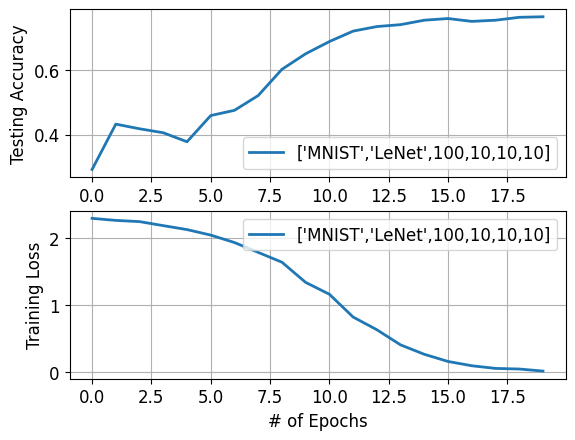

In [14]:
res_eval(args['sys_res_root'])